# Google-play App Review Sentiment Analysis with BERT 

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import json
from tqdm import tqdm

import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

# Google-Play-Scraper provides APIs to easily crawl the Google Play Store for Python without any external dependencies!
from google_play_scraper import Sort, reviews, app

%matplotlib inline

I0424 14:12:08.299082 14500 file_utils.py:35] PyTorch version 1.3.1 available.
I0424 14:12:10.643192 14500 file_utils.py:48] TensorFlow version 2.0.0 available.


In [2]:
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [3]:
def seed_everything(seed = 623):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

## Get top US APPs

In [5]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

## Get App Information

In [7]:
# Code from https://github.com/JoMingyu/google-play-scraper
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, 
               lang='en', # defaults to 'en'
               country='us') # defaults to 'us'
    del info['comments']
    app_infos.append(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.48it/s]


In [8]:
## Get information for all 15 APPs above
def print_json(json_object):
    json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [11]:
# Example
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"It\u2019s A MUST HAVE PLANNER & TO DO LIST APP\" (NYTimes, USA TODAY, WSJ & Lifehacker).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day C

## Convert the JSON objects to dataframe and to CSV

In [13]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

## Get App Reviews

In [16]:
# Code from https://github.com/JoMingyu/google-play-scraper
# Filter the review score.
# Then sort the reviews by their helpfulness
# Just in case, get a subset from the newest, too:
app_reviews = []

for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en', # defaults to 'en'
                country='us',# defaults to 'us'
                sort=sort_order,
                count= 200 if score == 3 else 100,
                filter_score_with=score # defaults to None(means all score)
              )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:13<00:00,  8.87s/it]


In [17]:
# Example
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2020-04-19 13:16:32",
  "content": "This application fails a lot and moreover it is complicated,weird and not intuitive. I don't renew my subscription.",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "4.19.0.6",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 1,
  "userImage": "https://lh3.googleusercontent.com/a-/AOh14Gg1TnyLdy95wr0sxvIJoYknH7bWwzgA7RGmVXXSkFQ",
  "userName": "Jo\u00e3o Manuel"
}



In [18]:
len(app_reviews)

15792

In [19]:
# Convert the JSON objects to dataframe and to CSV

In [20]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

# Sentiment Analysis with BERT and Transformers

In [4]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,João Manuel,https://lh3.googleusercontent.com/a-/AOh14Gg1T...,This application fails a lot and moreover it i...,1,1,4.19.0.6,2020-04-19 13:16:32,NaN,NaN,most_relevant,com.anydo
1,Anshul Rawal,https://lh3.googleusercontent.com/a-/AOh14GgH3...,"New update issue. In widget, when I tap to add...",1,0,4.19.0.6,2020-04-21 07:20:06,NaN,NaN,most_relevant,com.anydo
2,Jason Thornton,https://lh3.googleusercontent.com/-B4TxqW_x-Jo...,This could be an awesome app. It has great pot...,1,68,4.16.6.2,2020-02-07 11:01:02,"Hi Jason, as far as we can see in your latest ...",2020-02-09 04:37:41,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,195,4.17.0.2,2020-03-12 01:17:34,We do offer this option as part of the Advance...,2020-03-14 23:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,51,4.17.0.2,2020-03-14 10:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 16:45:51,most_relevant,com.anydo


In [5]:
# Check any missing value in review column ('content' here)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15792 entries, 0 to 15791
Data columns (total 11 columns):
userName                15792 non-null object
userImage               15792 non-null object
content                 15792 non-null object
score                   15792 non-null int64
thumbsUpCount           15792 non-null int64
reviewCreatedVersion    13572 non-null object
at                      15792 non-null object
replyContent            7538 non-null object
repliedAt               7538 non-null object
sortOrder               15792 non-null object
appId                   15792 non-null object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


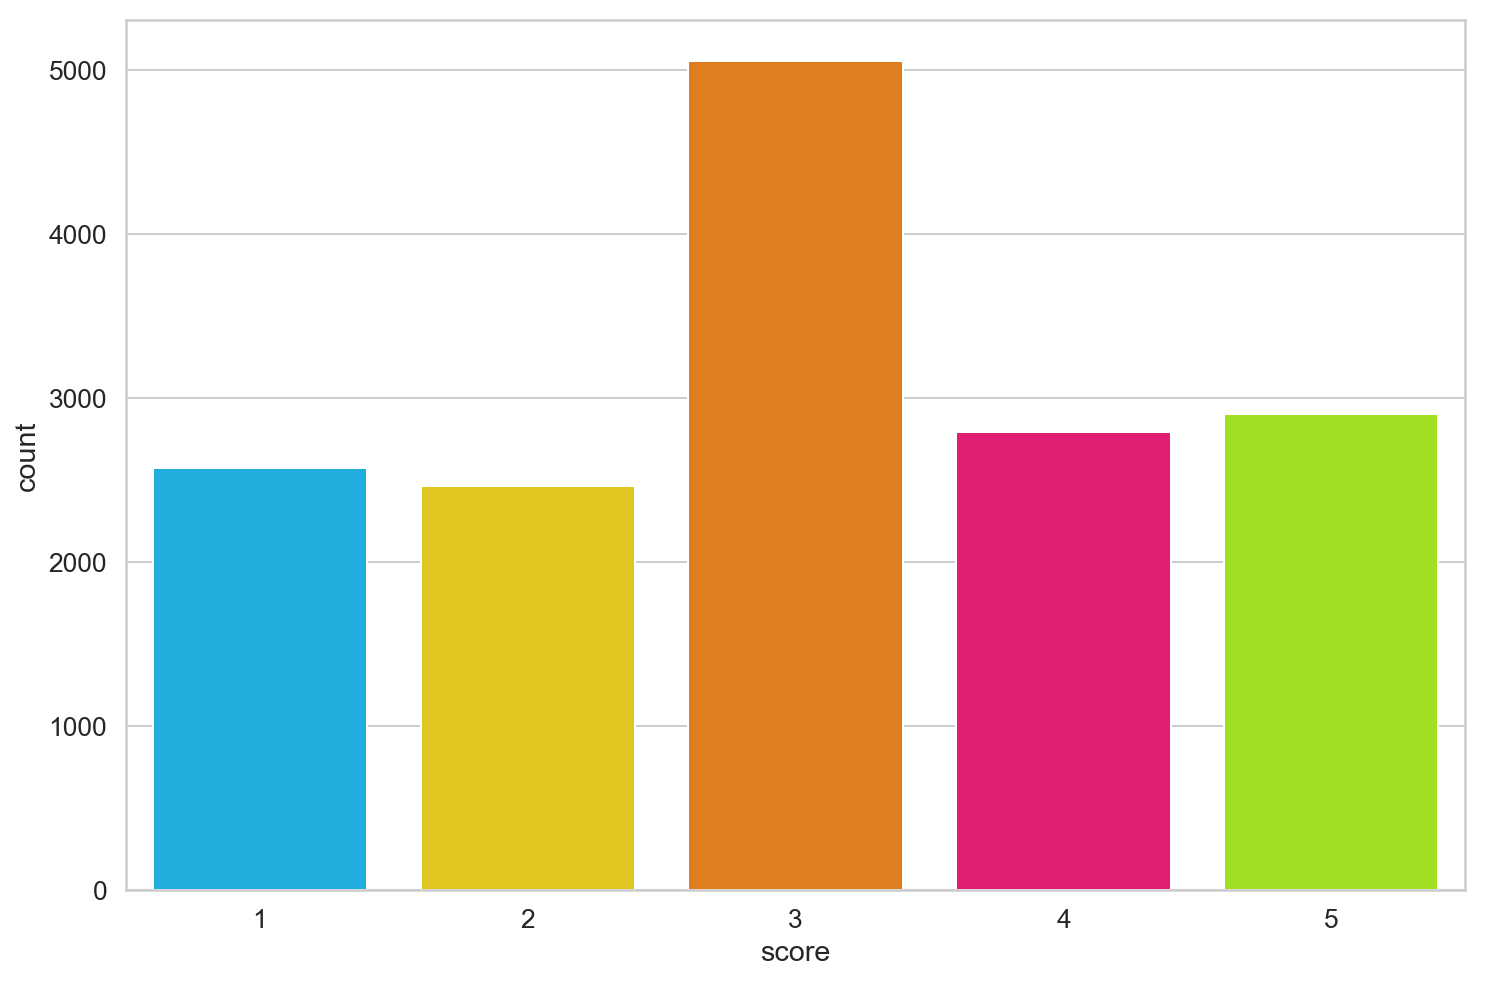

In [6]:
sns.countplot(df.score)

# Data Pre-processing

In [7]:
# Convert the dataset into negative, neutral and positive sentiment to make it balacned:
# Negative as 0
# Neutral as 1
# Positive as 2
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

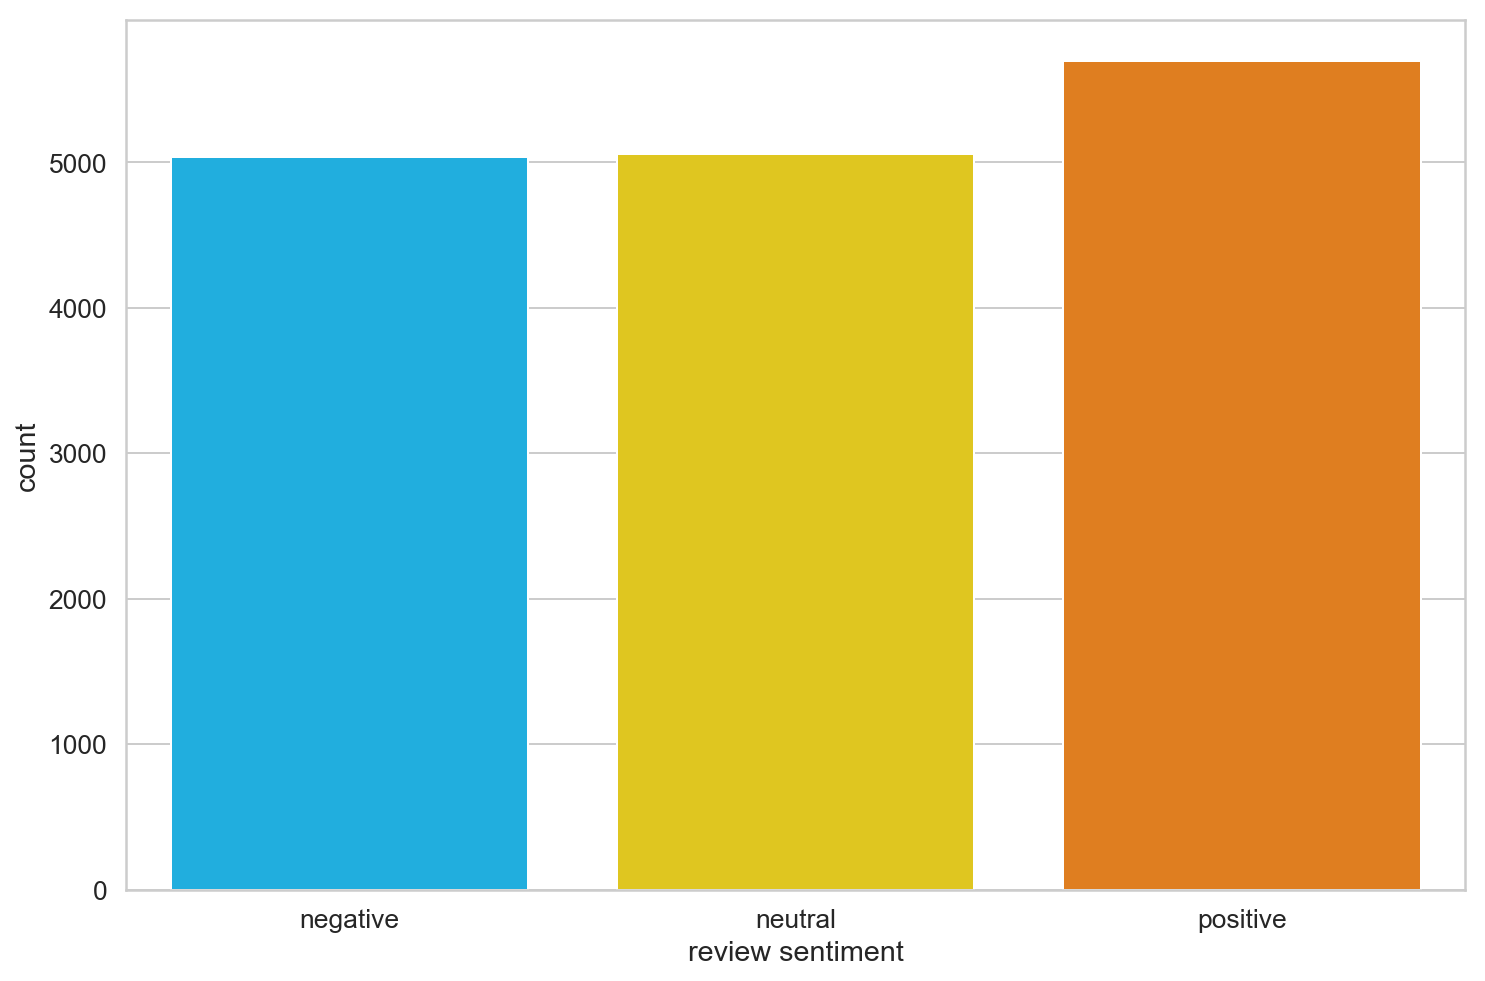

In [8]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU running

In [10]:
# The cased version works better. Intuitively, that makes sense, since “BAD” might convey more sentiment than “bad”.
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

I0424 14:12:48.610908 14500 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at C:\Users\bokhy\.cache\torch\transformers\5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [9]:
# Check the length of the token to optimize
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512) # set the max length for now (don't know the lengh of the review)
    token_lens.append(len(tokens))

# Most of the reviews seem to contain less than 128 tokens, but we’ll be on the safe side and choose a maximum length of 200.
sns.distplot(token_lens)

In [12]:
MAX_LEN = 200

# Create Pytorch Dataset

In [30]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True, # Add '[CLS]' and '[SEP]'
          max_length=self.max_len,
          return_token_type_ids=True, #False? 
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # Return PyTorch tensors
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

# Train/Test/Val Split

In [16]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5
)

In [17]:
df_train.shape, df_val.shape, df_test.shape

((14212, 12), (790, 12), (790, 12))

In [31]:
# Create DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0 # In Windows, it should be 0 (no multi-processing)
  )

In [32]:
# Create data Loader
BATCH_SIZE = 4 # or 16 (if enough memory)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Use base BertModel and build our sentiment classifier on top of it

In [20]:
# Load the base BertModel
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

I0424 14:13:02.420681 14500 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\bokhy\.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0424 14:13:02.422730 14500 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "o

In [33]:
# Sentiment Classifer on top of Bert Model
# We use a dropout layer for some regularization and a fully-connected layer for our output
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(                #pooled_output is a summary of the content
            input_ids=input_ids,
            attention_mask=attention_mask)
        
        output = self.drop(pooled_output)
        
        return self.out(output) # Note that we’re returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

In [34]:
# Create an instance on GPU 
model = SentimentClassifier(len(class_names))
model = model.to(device)

I0424 14:14:45.014093 14500 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\bokhy\.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0424 14:14:45.017090 14500 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "o

# Training

# BERT has some recommendations for fine-tuning:

## Batch size: 16, 32
## Learning rate (Adam): 5e-5, 3e-5, 2e-5
## Number of epochs: 2, 3, 4

In [35]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=0, # Linear scheduler with no warmup steps
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
# The scheduler gets called every time a batch is fed to the model. 
# We’re avoiding exploding gradients by clipping the gradients of the model using clipgrad_norm.
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids,attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
# Evaluation of model on a given data loader

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training Loop (Training + Evaluation Function)

In [41]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    # Saving history for plotting
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Storing the state of the best model that has the highest validation accuracy.
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.8248574028938145 accuracy 0.62278356318604
Val   loss 0.7498909547322928 accuracy 0.718987341772152

Epoch 2/3
----------
Train loss 0.6245774182465055 accuracy 0.8004503236701379
Val   loss 0.9060691505520031 accuracy 0.789873417721519

Epoch 3/3
----------
Train loss 0.4542284175153856 accuracy 0.8909372361384745
Val   loss 0.889203398742459 accuracy 0.8253164556962026

Wall time: 2h 34min 40s


# Training vs Validation Accuracy:

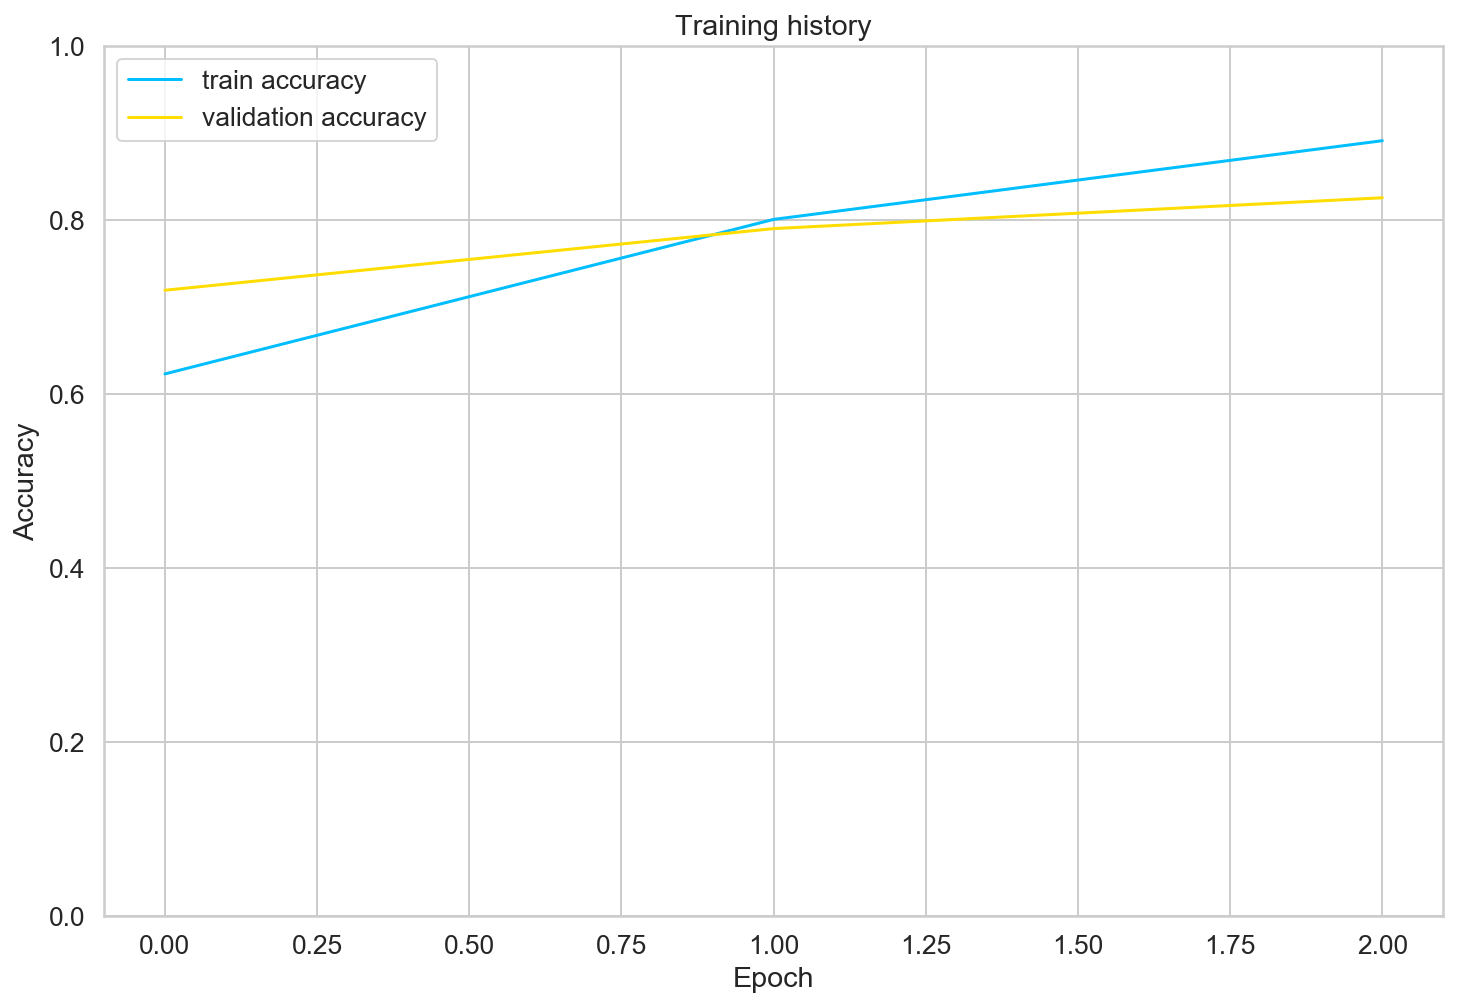

In [42]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Loading pre-trained model(from all the steps above)

In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

# Evaluating Test-set

In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8316455696202532

# Predictions

In [45]:
# Similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [46]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

In [47]:
#  classification report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83       258
     neutral       0.74      0.79      0.77       235
    positive       0.90      0.86      0.88       297

    accuracy                           0.83       790
   macro avg       0.83      0.83      0.83       790
weighted avg       0.83      0.83      0.83       790



# Predicting on Raw Text

In [48]:
review_text = "I love completing my todos! Best app ever!!!"

In [50]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True, #False?
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [51]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
